In [1]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.core.display import Markdown

import notebooks.config as config
import notebooks.utils as nb_utils
from src.db.broker import DbBroker
from src.features.initial_cleaning import InitialCleaner
from src.utils import Dataset, Metadata, preprocess_init

STAGE = 0

%load_ext autoreload
%autoreload 2

## Get dataset and metadata

In [2]:
def get_dataset_from_db() -> Dataset:
    db_broker = DbBroker()
    df = pd.read_sql(
        db_broker.get_all_listings_statement(),
        db_broker.engine,
        dtype_backend=config.DTYPE_BACKEND,
        index_col=config.INDEX,
    )
    df = df.rename(str, axis="columns")
    db_broker.engine.dispose()
    return df


def get_metadata() -> Metadata:
    return Metadata()

In [3]:
df = get_dataset_from_db()
metadata = get_metadata()

## Dataset info

In [4]:
print("Entire dataset")
print(f"Duplicate rows: {df.duplicated().sum()}")
print(20 * "-")
df.info()

Entire dataset
Duplicate rows: 0
--------------------
<class 'pandas.core.frame.DataFrame'>
Index: 30788 entries, 9249043 to 23246511
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   name                      30788 non-null  string
 1   short_url                 30788 non-null  string
 2   price                     30788 non-null  string
 3   listing_followers_no      30788 non-null  string
 4   location                  30788 non-null  string
 5   images_no                 30788 non-null  string
 6   safety                    30788 non-null  string
 7   equipment                 30788 non-null  string
 8   other                     30788 non-null  string
 9   description               30788 non-null  string
 10  id_1                      30788 non-null  Int64 
 11  condition                 30788 non-null  string
 12  brand                     30788 non-null  string
 13  model             

## Entire dataset cleaning

### Initial clean

In [5]:
@preprocess_init
def initial_preparation(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    df.columns = df.columns.astype("string")
    print("Transformed column type to string")

    # Prefix columns from table general_informations with "gi_"
    # and additional_informations with "ai"
    id_1_col_idx = df.columns.get_loc("id_1")
    id_2_col_idx = df.columns.get_loc("id_2")

    columns_from_gi = df.columns[id_1_col_idx + 1 : id_2_col_idx].values
    columns_from_ai = df.columns[id_2_col_idx + 1 :].values

    df.rename(columns=dict(zip(columns_from_gi, "gi_" + columns_from_gi)), inplace=True)
    print("Added prefix 'gi_' to columns from table general_informations")
    df.rename(columns=dict(zip(columns_from_ai, "ai_" + columns_from_ai)), inplace=True)
    print("Added prefix 'ai_' to columns from table additional_informations")

    del df["id_1"], df["id_2"]
    print("Removed redundant ids")

    del df["gi_fixed_price"]
    print("Removing gi_fixed_price that is poorly scraped")

    return df, metadata

In [6]:
df, metadata = initial_preparation(df=df, metadata=metadata)

Transformed column type to string
Added prefix 'gi_' to columns from table general_informations
Added prefix 'ai_' to columns from table additional_informations
Removed redundant ids
Removing gi_fixed_price that is poorly scraped


### Feature 'name'

In [7]:
@preprocess_init
def cf_name(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()
    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    print("Counts by frequencies for the first 20 categories")
    display(df[feature_name].value_counts().head(20))
    print()

    sum_irregular_name_rows = (
        df[feature_name].str.contains("ucesc|učešć", case=False).sum()
    )
    print(f"Irregular 'name' rows count: {sum_irregular_name_rows}")
    display(Markdown("This feature will be left for the Multivariate analysis."))
    print()

    features_info["other"].append(feature_name)
    print(f"Added {feature_name} to 'other' features")

    return df, metadata

In [8]:
df, metadata = cf_name(df=df, metadata=metadata)

First 5 rows


,name
id,
9249043,Volvo 940 DIPLOMATA NOV
9650557,"SsangYong Kyron 2,0 XDI4x4RESTAJLING"
9657017,Audi A4 2.5 TDI Quattro CH
9755964,Dacia Sandero 1.0 TCE 90 LAGER
9921885,Zastava 750 presla 38.400



Counts by frequencies for the first 20 categories


name
Audi A4                 179
Volkswagen Golf 5       123
Audi A6                 119
BMW 320                 115
Volkswagen Polo         114
Volkswagen Passat B6    106
Audi A3                 105
Renault Megane          102
Škoda Octavia           100
Volkswagen Golf 6        98
Volkswagen Golf 7        87
Ford Focus               82
Renault Clio             79
BMW 520                  73
Ford Fiesta              69
Fiat Punto               68
Opel Corsa D             68
Peugeot 308              67
Citroen C5               65
Audi A4 2.0 TDI          64
Name: count, dtype: Int64


Irregular 'name' rows count: 18


This feature will be left for the Multivariate analysis.


Added name to 'other' features


### Feature 'short_url'

In [9]:
@preprocess_init
def cf_short_url(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()
    features_info = metadata.features_info

    print("Display first 5 rows")
    display(df[[feature_name]].head())
    print()

    features_info["other"].append(feature_name)
    print(f"Added {feature_name} to 'other' features")

    return df, metadata

In [10]:
df, metadata = cf_short_url(df=df, metadata=metadata)

Display first 5 rows


,short_url
id,
9249043,https://www.polovniautomobili.com/auto-oglasi/...
9650557,https://www.polovniautomobili.com/auto-oglasi/...
9657017,https://www.polovniautomobili.com/auto-oglasi/...
9755964,https://www.polovniautomobili.com/auto-oglasi/...
9921885,https://www.polovniautomobili.com/auto-oglasi/...



Added short_url to 'other' features


### Feature 'price'

In [11]:
@preprocess_init
def cf_price(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    df[feature_name] = pd.to_numeric(
        df[feature_name].str.slice(stop=-1).str.replace(".", "").str.strip(),
        errors="raise",
        downcast="unsigned",
    )
    print("Removed '.' and spaces from values and transformed to numerical")
    print()

    print("Cars where price = 1")
    display(df[df[feature_name] == 1])
    display(
        Markdown(
            "These are cars where price='Po dogovoru' on the website, so that means they didn't have a price to begin with and they will be dropped."
        )
    )
    print()

    df = df.loc[df[feature_name] != 1, :]
    print("Removed cars that had price = 1")

    print("Cars where price = 'Po dogovoru'")
    display(df[df[feature_name] == "Po dogovoru"])
    print()

    cars_price_less_than_100 = df.loc[df[feature_name] < 100, feature_name]
    print("Short url of cars that had price < 100")
    display(df.loc[cars_price_less_than_100.index, "short_url"].tolist())  # type: ignore
    print()

    display(
        Markdown(
            "All of these cars are going to be deleted because they actually don't have a value of price (their current value is the result of poor handling the case when price is set by an agreement)."
        )
    )

    df = df.drop(cars_price_less_than_100.index, axis=0)
    print("Removed cars that had price < 100")

    return df, metadata

In [12]:
df, metadata = cf_price(df=df, metadata=metadata)

First 5 rows


,price
id,
9249043,18.000 €
9650557,4.500 €
9657017,3.300 €
9755964,16.100 €
9921885,12.999 €



Removed '.' and spaces from values and transformed to numerical

Cars where price = 1


,name,short_url,price,listing_followers_no,location,images_no,safety,equipment,other,description,...,ai_import_country,ai_sales_method,ai_credit,ai_deposit,ai_installment_no,ai_installment_amount,ai_interest_free_credit,ai_leasing,ai_cash_payment,ai_range_on_full_battery_km
id,,,,,,,,,,,,,,,,,,,,,
23220124,Audi A4 RATA 183e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,2,Beograd,39,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Daljinsko zaključavanje,Tonirana s...",,,...,<NA>,<NA>,DA,<NA>,<NA>,183 €,<NA>,<NA>,<NA>,<NA>
23220566,Renault Scenic RATA 148e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,,Beograd,28,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Multifunkcionalni volan,Tempomat,D...",,VOZILO U DOLASKU ...............................,...,<NA>,<NA>,DA,<NA>,<NA>,148 €,<NA>,<NA>,<NA>,<NA>
23221119,Opel Astra J RATA 148e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,1,Beograd,14,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Multifunkcionalni volan,Tempomat,D...",,Vozilo u dolasku ...............................,...,<NA>,<NA>,DA,<NA>,<NA>,148 €,<NA>,<NA>,<NA>,<NA>
23228430,Toyota Yaris RATA 78e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,1,1,Beograd,17,"Airbag za vozača,Airbag za suvozača,Bočni airb...","Servo volan,Daljinsko zaključavanje,Putni raču...",,VOZILO U DOLASKU,...,<NA>,<NA>,DA,<NA>,<NA>,78 €,<NA>,<NA>,<NA>,<NA>
23230448,Peugeot 306,https://www.polovniautomobili.com/auto-oglasi/...,1,2,Landol,19,"Airbag za vozača,Airbag za suvozača,ABS","Metalik boja,Servo volan,Tonirana stakla,Radio...",Garažiran,,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


These are cars where price='Po dogovoru' on the website, so that means they didn't have a price to begin with and they will be dropped.


Removed cars that had price = 1
Cars where price = 'Po dogovoru'


,name,short_url,price,listing_followers_no,location,images_no,safety,equipment,other,description,...,ai_import_country,ai_sales_method,ai_credit,ai_deposit,ai_installment_no,ai_installment_amount,ai_interest_free_credit,ai_leasing,ai_cash_payment,ai_range_on_full_battery_km
id,,,,,,,,,,,,,,,,,,,,,



Short url of cars that had price < 100


['https://www.polovniautomobili.com/auto-oglasi/22675403/Opel Meriva RATA 78e BEZ UCESCA',
 'https://www.polovniautomobili.com/auto-oglasi/22681873/Ford Focus RATA 83e BEZ UČEŠĆA',
 'https://www.polovniautomobili.com/auto-oglasi/22681890/Opel Astra H RATA 99e BEZ UČEŠĆA',
 'https://www.polovniautomobili.com/auto-oglasi/23225453/Zastava Yugo Tempo']

All of these cars are going to be deleted because they actually don't have a value of price (their current value is the result of poor handling the case when price is set by an agreement).

Removed cars that had price < 100


### Feature 'listing_followers_no'

In [13]:
@preprocess_init
def cf_listing_followers_no(
    df: Dataset, metadata: Metadata
) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    df[feature_name] = pd.to_numeric(
        df[feature_name], downcast="unsigned", errors="raise"
    )
    print("Transformed to numerical")

    features_info["numerical"].append(feature_name)
    print(f"Added '{feature_name}' to numerical features'")

    return df, metadata

In [14]:
df, metadata = cf_listing_followers_no(df=df, metadata=metadata)

First 5 rows


,listing_followers_no
id,
9249043,58
9650557,87
9657017,151
9755964,50
9921885,421



Transformed to numerical
Added 'listing_followers_no' to numerical features'


### Feature 'location'

In [15]:
@preprocess_init
def cf_location(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    df[feature_name] = pd.Categorical(df[feature_name].astype("object"), ordered=False)
    print(f"Converted '{feature_name}' to categorical type (nominal)")

    features_info["nominal"].append(feature_name)
    print(f"Added '{feature_name}' to 'nominal' features")

    return df, metadata

In [16]:
df, metadata = cf_location(df=df, metadata=metadata)

First 5 rows


,location
id,
9249043,Vrbas
9650557,Novi Sad
9657017,Loznica
9755964,Novi Sad
9921885,Zemun



Converted 'location' to categorical type (nominal)
Added 'location' to 'nominal' features


### Feature 'images_no'

In [17]:
@preprocess_init
def cf_images_no(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    df[feature_name] = pd.to_numeric(
        df[feature_name], downcast="unsigned", errors="raise"
    )
    print("Transformed to numerical")

    features_info["numerical"].append(feature_name)
    print(f"Added {feature_name} to 'numerical' features")

    return df, metadata

In [18]:
df, metadata = cf_images_no(df=df, metadata=metadata)

First 5 rows


,images_no
id,
9249043,30
9650557,17
9657017,19
9755964,9
9921885,15



Transformed to numerical
Added images_no to 'numerical' features


### Feature 'safety'

In [19]:
@preprocess_init
def cf_safety(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    prefix = "s_"

    # Create data frame with dummy columns
    df_safety_dummies = df[feature_name].str.get_dummies(sep=",").add_prefix(prefix)
    df = pd.concat([df, df_safety_dummies], axis=1)
    print("Extended the data frame with dummy columns")

    del df[feature_name]
    print(f"Deleted '{feature_name}' column")

    safety_columns = [col for col in df.columns if col.startswith(prefix)]
    df[safety_columns] = df[safety_columns].astype("boolean")
    print("Converted all remaining safety columns to boolean")

    safety_columns_fixed = (
        df[safety_columns]
        .columns.str.strip()
        .str.replace(r"[- ]", "_", regex=True)
        .str.replace("/", "_ili_")
    ).tolist()

    df.rename(columns=dict(zip(safety_columns, safety_columns_fixed)), inplace=True)
    print("Fixed column names")

    features_info["binary"].extend(safety_columns_fixed)
    print("Added all remaining safety columns to 'binary' features")

    return df, metadata

In [20]:
df, metadata = cf_safety(df=df, metadata=metadata)

First 5 rows


,safety
id,
9249043,
9650557,"Airbag za vozača,Airbag za suvozača,Bočni airb..."
9657017,"Airbag za vozača,Airbag za suvozača,Bočni airb..."
9755964,"Airbag za vozača,Airbag za suvozača,Bočni airb..."
9921885,



Extended the data frame with dummy columns
Deleted 'safety' column
Converted all remaining safety columns to boolean
Fixed column names
Added all remaining safety columns to 'binary' features


### Feature 'equipment'

In [21]:
@preprocess_init
def cf_equipment(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    prefix = "e_"

    # Create data frame with dummy columns
    df_equipment_dummies = df[feature_name].str.get_dummies(sep=",").add_prefix(prefix)
    df = pd.concat([df, df_equipment_dummies], axis=1)
    print("Extended the data frame with dummy columns")

    del df[feature_name]
    print(f"Deleted '{feature_name}' column")

    equipment_columns = df_equipment_dummies.columns.tolist()

    df[equipment_columns] = df[equipment_columns].astype("boolean")
    print("Converted all remaining equipment columns to boolean")

    equipment_columns_fixed = (
        df[equipment_columns]
        .columns.str.strip()
        .str.replace(r"[- ]", "_", regex=True)
        .str.replace("/", "_ili_")
    ).tolist()

    df.rename(
        columns=dict(zip(equipment_columns, equipment_columns_fixed)), inplace=True
    )
    print("Fixed column names")

    features_info["binary"].extend(equipment_columns_fixed)
    print("Added all remaining equipment columns to 'binary' features")

    return df, metadata

In [22]:
df, metadata = cf_equipment(df=df, metadata=metadata)

First 5 rows


,equipment
id,
9249043,
9650557,"Metalik boja,Branici u boji auta,Servo volan,M..."
9657017,"Metalik boja,Branici u boji auta,Servo volan,T..."
9755964,"Metalik boja,Branici u boji auta,Servo volan,M..."
9921885,Svetla za maglu



Extended the data frame with dummy columns
Deleted 'equipment' column
Converted all remaining equipment columns to boolean
Fixed column names
Added all remaining equipment columns to 'binary' features


### Feature 'other'

In [23]:
@preprocess_init
def cf_other(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    prefix = "o_"

    # Create data frame with dummy columns
    df_other_dummies = df[feature_name].str.get_dummies(sep=",").add_prefix(prefix)
    df = pd.concat([df, df_other_dummies], axis=1)
    print("Extended the data frame with dummy columns")

    del df[feature_name]
    print(f"Deleted '{feature_name}' column")

    other_columns = df_other_dummies.columns.tolist()

    df[other_columns] = df[other_columns].astype("boolean")
    print("Converted all remaining other columns to boolean")

    other_columns_fixed = (
        df[other_columns]
        .columns.str.strip()
        .str.replace(r"[- ]", "_", regex=True)
        .str.replace("/", "_ili_")
    ).tolist()

    df.rename(columns=dict(zip(other_columns, other_columns_fixed)), inplace=True)
    print("Fixed column names")

    df = df.loc[df.o_Taxi == False, :]
    del df["o_Taxi"]
    other_columns_fixed.remove("o_Taxi")
    print("Deleted taxi cars and the column")

    df = df.loc[df.o_Vozilo_auto_škole == False, :]
    del df["o_Vozilo_auto_škole"]
    other_columns_fixed.remove("o_Vozilo_auto_škole")
    print("Deleted driving school cars and the column")

    features_info["binary"].extend(other_columns_fixed)
    print("Added all remaining other columns to 'binary' features")

    return df, metadata

In [24]:
df, metadata = cf_other(df=df, metadata=metadata)

First 5 rows


,other
id,
9249043,
9650557,Rezervni ključ
9657017,"Servisna knjiga,Rezervni ključ"
9755964,"Prvi vlasnik,Kupljen nov u Srbiji,Garancija,Ga..."
9921885,"Kupljen nov u Srbiji,Garancija,Garažiran,Servi..."



Extended the data frame with dummy columns
Deleted 'other' column
Converted all remaining other columns to boolean
Fixed column names
Deleted taxi cars and the column
Deleted driving school cars and the column
Added all remaining other columns to 'binary' features


### Feature 'description'

In [25]:
@preprocess_init
def cf_description(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    feature_name = nb_utils.get_feature_name()

    features_info = metadata.features_info

    print("First 5 rows")
    display(df[[feature_name]].head())
    print()

    features_info["other"].append(feature_name)
    print(f"Added '{feature_name}' to 'other' features")

    return df, metadata

In [26]:
df, metadata = cf_description(df=df, metadata=metadata)

First 5 rows


,description
id,
9249043,"DIPLOMATA,JEDINSTVEN SA MALOM KILOMETRAZOM,(25..."
9650557,Vozilo u odlicnom stanju ...
9657017,- A4 Quattro - manuelni menjac - Uvoz iz Svjca...
9755964,"NOVO VOZILO, ODLICNI USLOVI FINANSIRANJA . OVL..."
9921885,Fica ima pravih 38.400 km !!! Nikad nije nist...



Added 'description' to 'other' features


### "GeneralInformation" features

In [27]:
@preprocess_init
def c_general_informations(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    pd.set_option("mode.chained_assignment", None)

    features_info = metadata.features_info

    gi_columns = [
        "gi_condition",
        "gi_brand",
        "gi_model",
        "gi_production_year",
        "gi_kilometerage",
        "gi_body_type",
        "gi_fuel_type",
        "gi_engine_capacity",
        "gi_engine_power",
        "gi_trade_in",
        "gi_certified",
        "gi_battery_capacity",
    ]

    print("Frequencies for GeneralInformation columns")
    for col in gi_columns:
        display(nb_utils.get_value_counts_freq_with_perc(df, col))

    display(
        Markdown(
            "Only used cars will be left in the dataset, so all new cars are going to be deleted."
        )
    )

    new_cars_cond = df.gi_condition == "Novo vozilo"
    df = df.loc[~new_cars_cond, :]
    print(f"Deleted from df {new_cars_cond.sum()} rows that represent new cars")

    del df["gi_condition"]
    print("Deleted 'gi_condition' feature")

    df.gi_kilometerage = (
        df.gi_kilometerage.str.rstrip("km").str.replace(".", "").str.strip()
    )
    print("Stripped 'km' and spaces and removed '.' from 'gi_kilometerage'")

    df.gi_production_year = df.gi_production_year.str.rstrip(".").str.strip()
    print("Removed '.' and stripped spaces from 'gi_production_year'")

    df.gi_engine_capacity = df.gi_engine_capacity.str.rstrip("cm3").str.strip()
    print("Stripped 'cm3' and spaces from 'gi_engine_capacity'")

    df.gi_engine_power = df.gi_engine_power.str.split("/", n=1).str.get(0).str.strip()
    print("Extracted only value of KS (stands for horse powers) and stripped spaces")

    df.gi_certified = pd.to_datetime(
        df.gi_certified.str.strip()
        .str.lstrip("do: ")
        .replace({"Nije atestiran": np.nan}),
        format="%m.%Y",
        errors="raise",
    )
    print(
        "Stripped spaces and 'do: ' from 'gi_certified', replaced 'Nije atestiran' with NA and transformed to datetime"
    )

    df.gi_battery_capacity = df.gi_battery_capacity.str.rstrip("kWh").str.strip()
    print("Stripped 'kWh' and spaces from 'gi_battery_capacity'")

    nominal_cols = [
        "gi_brand",
        "gi_model",
        "gi_body_type",
        "gi_fuel_type",
        "gi_trade_in",
    ]
    numerical_cols = [
        "gi_kilometerage",
        "gi_production_year",
        "gi_engine_capacity",
        "gi_engine_power",
        "gi_battery_capacity",
    ]
    other_cols = ["gi_certified"]

    for col in nominal_cols:
        df[col] = pd.Categorical(df[col].astype("object"), ordered=False)
    print("Converted nominal columns to categorical types (nominal)")

    for col in numerical_cols:
        df[col] = pd.to_numeric(df[col], errors="raise", downcast="unsigned")
    print("Converted numerical columns to numerical types")

    features_info["nominal"].extend(nominal_cols)
    print(f"Added {nominal_cols} columns to 'nominal' features")
    features_info["numerical"].extend(numerical_cols)
    print(f"Added {numerical_cols} columns to 'numerical' features")
    features_info["other"].extend(other_cols)
    print(f"Added {other_cols} columns to 'other' features")

    pd.set_option("mode.chained_assignment", "warn")

    return df, metadata

In [28]:
df, metadata = c_general_informations(df=df, metadata=metadata)

Frequencies for GeneralInformation columns


,count,percentage [%]
gi_condition,,
Polovno vozilo,30114,97.912602
Novo vozilo,642,2.087398


,count,percentage [%]
gi_brand,,
Volkswagen,4809,15.635973
Audi,3188,10.365457
BMW,2770,9.006373
Opel,2376,7.725322
Peugeot,2053,6.67512
...,...,...
Oldsmobile,1,0.003251
Jinpeng,1,0.003251
Lamborghini,1,0.003251


,count,percentage [%]
gi_model,,
A4,866,2.815711
Octavia,630,2.048381
A3,628,2.041878
A6,621,2.019118
Golf 7,573,1.863051
...,...,...
CLK 240,1,0.003251
CLS 300,1,0.003251
Explorer,1,0.003251


,count,percentage [%]
gi_production_year,,
2008.,1983,6.447522
2011.,1975,6.421511
2010.,1870,6.080114
2009.,1838,5.97607
2007.,1829,5.946807
...,...,...
1957.,1,0.003251
1961.,1,0.003251
1973.,1,0.003251


,count,percentage [%]
gi_kilometerage,,
250.000 km,379,1.23228
230.000 km,334,1.085967
220.000 km,326,1.059956
0 km,323,1.050202
200.000 km,303,0.985174
...,...,...
214.393 km,1,0.003251
183.548 km,1,0.003251
280.200 km,1,0.003251


,count,percentage [%]
gi_body_type,,
Hečbek,10408,33.840551
Džip/SUV,6342,20.620367
Limuzina,5630,18.305371
Karavan,4601,14.959683
Monovolumen (MiniVan),2441,7.936663
Kupe,809,2.630381
Kabriolet/Roadster,315,1.02419
Pickup,208,0.676291
,2,0.006503


,count,percentage [%]
gi_fuel_type,,
Dizel,20730,67.401483
Benzin,7779,25.292626
Benzin + Gas (TNG),1134,3.687085
Benzin + Metan (CNG),553,1.798023
Hibridni pogon,327,1.063207
Električni pogon,181,0.588503
Hibridni pogon (Benzin),34,0.110548
Hibridni pogon (Dizel),14,0.04552
Plug-in hibrid,3,0.009754


,count,percentage [%]
gi_engine_capacity,,
1968 cm3,3569,11.60424
1598 cm3,2742,8.915334
1995 cm3,2111,6.863701
1560 cm3,1473,4.789309
1461 cm3,1219,3.963454
...,...,...
1480 cm3,1,0.003251
190 cm3,1,0.003251
699 cm3,1,0.003251


,count,percentage [%]
gi_engine_power,,
110/150 (kW/KS),2513,8.170763
103/140 (kW/KS),1923,6.252439
85/116 (kW/KS),1651,5.368058
77/105 (kW/KS),1438,4.67551
81/110 (kW/KS),1333,4.334114
...,...,...
60/81 (kW/KS),1,0.003251
146/199 (kW/KS),1,0.003251
500/680 (kW/KS),1,0.003251


,count,percentage [%]
gi_trade_in,,
NE,22561,73.354793
DA,3740,12.160229
DA (za jeftinije),2824,9.181948
DA (za skuplje),991,3.222136
DA (u istoj ceni),438,1.424112
DA (staro za novo),202,0.656782


,count,percentage [%]
gi_certified,,
<NA>,29068,94.51164
Nije atestiran,163,0.529978
do: 10.2027,54,0.175575
do: 07.2027,49,0.159319
do: 01.2028,49,0.159319
...,...,...
do: 10.2032,1,0.003251
do: 10.2030,1,0.003251
do: 04.2031,1,0.003251


,count,percentage [%]
gi_battery_capacity,,
<NA>,30575,99.411497
17 kWh,11,0.035765
75 kWh,10,0.032514
58 kWh,7,0.02276
22 kWh,7,0.02276
...,...,...
21.6 kWh,1,0.003251
38.3 kWh,1,0.003251
72.6 kWh,1,0.003251


Only used cars will be left in the dataset, so all new cars are going to be deleted.

Deleted from df 642 rows that represent new cars
Deleted 'gi_condition' feature
Stripped 'km' and spaces and removed '.' from 'gi_kilometerage'
Removed '.' and stripped spaces from 'gi_production_year'
Stripped 'cm3' and spaces from 'gi_engine_capacity'
Extracted only value of KS (stands for horse powers) and stripped spaces
Stripped spaces and 'do: ' from 'gi_certified', replaced 'Nije atestiran' with NA and transformed to datetime
Stripped 'kWh' and spaces from 'gi_battery_capacity'
Converted nominal columns to categorical types (nominal)
Converted numerical columns to numerical types
Added ['gi_brand', 'gi_model', 'gi_body_type', 'gi_fuel_type', 'gi_trade_in'] columns to 'nominal' features
Added ['gi_kilometerage', 'gi_production_year', 'gi_engine_capacity', 'gi_engine_power', 'gi_battery_capacity'] columns to 'numerical' features
Added ['gi_certified'] columns to 'other' features


### "AdditionalInformation" features

In [29]:
@preprocess_init
def c_additional_informations(
    df: Dataset, metadata: Metadata
) -> tuple[Dataset, Metadata]:
    features_info = metadata.features_info

    ai_columns = [col for col in df.columns if "ai_" in col]

    pd.set_option("mode.chained_assignment", None)

    print("Frequencies for AdditionalInformation columns")
    for col in ai_columns:
        display(nb_utils.get_value_counts_freq_with_perc(df, col))

    df.ai_engine_emission_class = df.ai_engine_emission_class.str.lstrip(
        "Euro"
    ).str.strip()
    print("Stripped 'Euro' and spaces from 'ai_engine_emission_class'")

    df.ai_doors_no = df.ai_doors_no.map({"4/5 vrata": True, "2/3 vrata": False})
    print(
        "Stripped spaces and mapped 'ai_doors_no' so that True represents 4/5 doors and False 2/3 doors"
    )

    df.ai_seats_no = df.ai_seats_no.str.rstrip("sedišta").str.strip()
    print("Stripped 'sedišta' and spaces from 'ai_seats_no")

    df = df.loc[df.ai_steering_wheel_side.str.strip() != "Desni volan", :]
    print("Kept only cars that have steering wheele on the right side")

    del df["ai_steering_wheel_side"]
    print("Deleted 'ai_steering_wheel_side' feature (no longer useful)")

    df.ai_registered_until = pd.to_datetime(
        df.ai_registered_until.str.strip().replace({"Nije registrovan": np.nan}),
        format="%m.%Y.",
        errors="raise",
    )
    print(
        "Stripped spaces from 'ai_registered_until', replaced 'Nije registrovan' with NA and transformed to datetime"
    )

    df.ai_credit = df.ai_credit.str.strip().map({"DA": True, np.nan: False})
    print(
        "Stripped spaces and mapped 'ai_credit' so that True represents 'DA' and False <NA>"
    )

    df.ai_deposit = df.ai_deposit.str.rstrip("€").str.strip()
    print("Stripped '€' and spaces from 'ai_deposit'")

    df.ai_installment_amount = df.ai_installment_amount.str.rstrip("€").str.strip()
    print("Stripped '€' and spaces from 'ai_installment_amount'")

    df.ai_interest_free_credit = df.ai_interest_free_credit.str.strip().map(
        {"DA": True, np.nan: False}
    )
    print(
        "Stripped spaces and mapped 'ai_interest_free_credit' so that True represents 'DA' and False <NA>"
    )

    df.ai_leasing = df.ai_leasing.str.strip().map({"DA": True, np.nan: False})
    print(
        "Stripped spaces and mappped 'ai_leasing' so that True represents 'DA' and False <NA>"
    )

    df.ai_cash_payment = df.ai_cash_payment.str.rstrip("€").str.strip()
    print("Stripped '€' and spaces from 'ai_cash_payment'")

    binary_cols = ["ai_doors_no", "ai_credit", "ai_interest_free_credit", "ai_leasing"]
    ordinal_cols = ["ai_engine_emission_class", "ai_damage"]
    nominal_cols = [
        "ai_floating_flywheel",
        "ai_gearbox_type",
        "ai_air_conditioning",
        "ai_color",
        "ai_interior_material",
        "ai_interior_color",
        "ai_propulsion",
        "ai_vehicle_origin",
        "ai_ownership",
        "ai_import_country",
        "ai_sales_method",
    ]
    numerical_cols = [
        "ai_seats_no",
        "ai_deposit",
        "ai_installment_no",
        "ai_installment_amount",
        "ai_cash_payment",
        "ai_range_on_full_battery_km",
    ]
    other_cols = [
        "ai_registered_until",
    ]

    df[binary_cols] = df[binary_cols].astype("boolean")
    print("Converted binary columns to boolean")

    for col in ordinal_cols:
        df[col] = pd.Categorical(df[col].astype("object"), ordered=True)
    print("Converted ordinal columns to categorical types (ordinal)")

    for col in nominal_cols:
        df[col] = pd.Categorical(df[col].astype("object"), ordered=False)
    print("Converted nominal columns to categorical types (nominal)")

    for col in numerical_cols:
        df[col] = pd.to_numeric(df[col], errors="raise", downcast="unsigned")
    print("Converted numerical columns to numerical types")

    features_info["binary"].extend(binary_cols)
    print(f"Added {binary_cols} columns to 'binary' features")
    features_info["ordinal"].extend(ordinal_cols)
    print(f"Added {ordinal_cols} columns to 'ordinal' features")
    features_info["nominal"].extend(nominal_cols)
    print(f"Added {nominal_cols} columns to 'nominal' features")
    features_info["numerical"].extend(numerical_cols)
    print(f"Added {numerical_cols} columns to 'numerical' features")
    features_info["other"].extend(other_cols)
    print(f"Added {other_cols} columns to 'other' features")

    pd.set_option("mode.chained_assignment", "warn")

    return df, metadata

In [30]:
df, metadata = c_additional_informations(df=df, metadata=metadata)

Frequencies for AdditionalInformation columns


,count,percentage [%]
ai_floating_flywheel,,
<NA>,20483,68.018198
Sa plivajućim zamajcem,6209,20.618317
Bez plivajućeg zamajca,3422,11.363485


,count,percentage [%]
ai_engine_emission_class,,
Euro 4,8981,29.823338
Euro 6,8919,29.617454
Euro 5,8354,27.74125
Euro 3,3207,10.649532
Euro 2,386,1.281796
Euro 1,260,0.863386
<NA>,7,0.023245


,count,percentage [%]
ai_propulsion,,
Prednji,21818,72.451352
4x4,5032,16.709836
Zadnji,2656,8.819818
4x4 reduktor,608,2.018994


,count,percentage [%]
ai_gearbox_type,,
Manuelni 5 brzina,10632,35.305838
Manuelni 6 brzina,10185,33.821478
Automatski / poluautomatski,9125,30.301521
Manuelni 4 brzine,154,0.51139
Automatski,16,0.053131
Poluautomatski,1,0.003321
<NA>,1,0.003321


,count,percentage [%]
ai_doors_no,,
4/5 vrata,27013,89.702464
2/3 vrata,3099,10.290895
<NA>,2,0.006641


,count,percentage [%]
ai_seats_no,,
5 sedišta,26966,89.54639
4 sedišta,1785,5.927476
7 sedišta,932,3.094906
2 sedišta,344,1.142326
6 sedišta,48,0.159394
3 sedišta,18,0.059773
8 sedišta,13,0.043169
9 sedišta,8,0.026566


,count,percentage [%]
ai_steering_wheel_side,,
Levi volan,29970,99.521817
Desni volan,144,0.478183


,count,percentage [%]
ai_air_conditioning,,
Automatska klima,20436,67.862124
Manuelna klima,8699,28.886896
Nema klimu,979,3.25098


,count,percentage [%]
ai_color,,
Siva,9672,32.117952
Crna,7826,25.987913
Bela,4446,14.763897
Plava,2765,9.181776
Crvena,1379,4.579265
Srebrna,740,2.457329
Teget,714,2.37099
Braon,563,1.869562
Zelena,507,1.683602


,count,percentage [%]
ai_interior_material,,
Štof,16250,53.961613
Prirodna koža,5187,17.224547
<NA>,4083,13.558478
Kombinovana koža,3654,12.133891
Drugi,483,1.603905
Velur,457,1.517567


,count,percentage [%]
ai_interior_color,,
Crna,15362,51.012818
Siva,5785,19.210334
<NA>,5241,17.403865
Druga,1693,5.62197
Bež,1400,4.649
Smeđa,633,2.102012


,count,percentage [%]
ai_registered_until,,
Nije registrovan,12981,43.106196
07.2024.,1492,4.954506
06.2024.,1485,4.931261
05.2024.,1437,4.771867
04.2024.,1418,4.708773
12.2024.,1390,4.615793
08.2024.,1380,4.582586
11.2024.,1363,4.526134
10.2024.,1350,4.482965


,count,percentage [%]
ai_vehicle_origin,,
Domaće tablice,18392,61.074583
Na ime kupca,11513,38.231387
Strane tablice,207,0.687388
<NA>,2,0.006641


,count,percentage [%]
ai_ownership,,
Vodi se na prodavca,12868,42.730956
<NA>,11746,39.005114
Ne vodi se na prodavca,5500,18.26393


,count,percentage [%]
ai_damage,,
Nije oštećen,29733,98.734808
Oštećen - u voznom stanju,232,0.770406
Oštećen - nije u voznom stanju,144,0.478183
<NA>,5,0.016604


,count,percentage [%]
ai_import_country,,
<NA>,22520,74.782493
Švajcarska,2035,6.757654
Italija,1370,4.549379
Francuska,1253,4.160855
Nemačka,1075,3.569768
Holandija,667,2.214917
Belgija,367,1.218702
Norveška,259,0.860065
Austrija,203,0.674105


,count,percentage [%]
ai_sales_method,,
<NA>,27075,89.908348
Komisiona,2761,9.168493
Konsignaciona,278,0.923159


,count,percentage [%]
ai_credit,,
<NA>,28297,93.966262
DA,1817,6.033738


,count,percentage [%]
ai_deposit,,
<NA>,29641,98.429302
30 €,31,0.102942
3000 €,20,0.066414
6000 €,17,0.056452
4800 €,9,0.029886
...,...,...
1948 €,1,0.003321
3225 €,1,0.003321
3380 €,1,0.003321


,count,percentage [%]
ai_installment_no,,
<NA>,29504,97.974364
84,331,1.099157
60,137,0.454938
70,42,0.13947
71,24,0.079697
36,15,0.049811
48,13,0.043169
24,10,0.033207
42,8,0.026566


,count,percentage [%]
ai_installment_amount,,
<NA>,29536,98.080627
115 €,18,0.059773
150 €,11,0.036528
94 €,9,0.029886
140 €,9,0.029886
...,...,...
304 €,1,0.003321
227 €,1,0.003321
700 €,1,0.003321


,count,percentage [%]
ai_interest_free_credit,,
<NA>,29928,99.382347
DA,186,0.617653


,count,percentage [%]
ai_leasing,,
<NA>,29327,97.386598
DA,787,2.613402


,count,percentage [%]
ai_cash_payment,,
<NA>,29831,99.060238
3000 €,10,0.033207
5000 €,10,0.033207
6000 €,8,0.026566
2500 €,8,0.026566
...,...,...
19970 €,1,0.003321
3660 €,1,0.003321
23700 €,1,0.003321


,count,percentage [%]
ai_range_on_full_battery_km,,
<NA>,29987,99.578269
300,10,0.033207
140,7,0.023245
150,6,0.019924
400,6,0.019924
50,5,0.016604
120,5,0.016604
160,5,0.016604
130,5,0.016604


Stripped 'Euro' and spaces from 'ai_engine_emission_class'
Stripped spaces and mapped 'ai_doors_no' so that True represents 4/5 doors and False 2/3 doors
Stripped 'sedišta' and spaces from 'ai_seats_no
Kept only cars that have steering wheele on the right side
Deleted 'ai_steering_wheel_side' feature (no longer useful)
Stripped spaces from 'ai_registered_until', replaced 'Nije registrovan' with NA and transformed to datetime
Stripped spaces and mapped 'ai_credit' so that True represents 'DA' and False <NA>
Stripped '€' and spaces from 'ai_deposit'
Stripped '€' and spaces from 'ai_installment_amount'
Stripped spaces and mapped 'ai_interest_free_credit' so that True represents 'DA' and False <NA>
Stripped spaces and mappped 'ai_leasing' so that True represents 'DA' and False <NA>
Stripped '€' and spaces from 'ai_cash_payment'
Converted binary columns to boolean
Converted ordinal columns to categorical types (ordinal)
Converted nominal columns to categorical types (nominal)
Converted nume

### Remove new cars

In [31]:
@preprocess_init
def new_cars(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    """Insight gained in UnivariateAnalysis."""
    
    idx_to_remove = metadata.idx_to_remove
    df_cars_with_0_kilometerage = df[df.gi_kilometerage == 0]

    df.drop(df_cars_with_0_kilometerage.index, inplace=True)
    idx_to_remove.extend(df_cars_with_0_kilometerage.index.to_list())
    print("Remove cars with 'gi_kilometerage' = 0")

    return df, metadata

In [32]:
df, metadata = new_cars(df, metadata)

Remove cars with 'gi_kilometerage' = 0


### Irregular label rows

In [33]:
@preprocess_init
def irregular_label_rows(
    df: Dataset, metadata: Metadata
) -> tuple[Dataset, Metadata]:
    """Insight gained in MultivariateAnalysis."""
    
    idx_to_remove = metadata.idx_to_remove

    print("Cars that contain 'ucesc' or 'učešć' in the 'name' column")
    no_price_cond = df["name"].str.contains("ucesc|učešć", case=False)
    display(
        df.loc[no_price_cond, ["name", "short_url", "ai_installment_amount", "price"]]
    )
    print()

    display(
        Markdown("It can be seen that some cars had value of price, but some didn't.")
    )
    print()

    print("Cars where 'price' = 'ai_installment_amount'")
    df_cars_equal_price_install_amt = df.loc[
        df.price == df.ai_installment_amount, :
    ]
    display(df_cars_equal_price_install_amt)
    print()

    df.drop(df_cars_equal_price_install_amt.index, axis=0, inplace=True)
    print("Removed cars where 'price' = 'ai_installment_amount'")

    idx_to_remove.extend(df_cars_equal_price_install_amt.index.tolist())

    return df, metadata

In [34]:
df, metadata = irregular_label_rows(df=df, metadata=metadata)

Cars that contain 'ucesc' or 'učešć' in the 'name' column


,name,short_url,ai_installment_amount,price
id,,,,
21787916,Fiat Grande Punto 104e RATA BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,104,104
22681838,BMW X1 RATA 222e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,222,222
22681846,Renault Scenic RATA 114e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,114,114
22681931,Fiat EVO RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,107
22681938,Volkswagen Golf 5 RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,107
22898494,Škoda Superb RATA 314e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,314,314
22903371,BMW 420 RATA 426e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,426,19499
22903376,Škoda Superb RATA 171e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,171,171
22969571,BMW 318 RATA 130e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,130,130


It can be seen that some cars had value of price, but some didn't.


Cars where 'price' = 'ai_installment_amount'


,name,short_url,price,listing_followers_no,location,images_no,description,gi_brand,gi_model,gi_production_year,...,o_Garažiran,o_Kupljen_nov_u_Srbiji,o_Oldtimer,o_Prilagođeno_invalidima,o_Prvi_vlasnik,o_Restauriran,o_Rezervni_ključ,o_Servisna_knjiga,o_Test_vozilo,o_Tuning
id,,,,,,,,,,,,,,,,,,,,,
21787916,Fiat Grande Punto 104e RATA BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,104,54,Beograd,27,................................DOBRODOSLI U A...,Fiat,Grande Punto,2011,...,False,False,False,False,False,False,False,False,False,False
22681838,BMW X1 RATA 222e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,222,22,Beograd,44,................................DOBRODOSLI U A...,BMW,X1,2011,...,False,False,False,False,False,False,False,False,False,False
22681846,Renault Scenic RATA 114e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,114,8,Beograd,23,................................DOBRODOSLI U A...,Renault,Scenic,2010,...,False,False,False,False,False,False,False,False,False,False
22681931,Fiat EVO RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,15,Beograd,32,................................DOBRODOSLI U A...,Fiat,EVO,2011,...,False,False,False,False,False,False,False,False,False,False
22681938,Volkswagen Golf 5 RATA 107e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,107,26,Beograd,30,................................DOBRODOSLI U A...,Volkswagen,Golf 5,2006,...,False,False,False,False,False,False,False,False,False,False
22898494,Škoda Superb RATA 314e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,314,28,Beograd,48,................................DOBRODOSLI U A...,Škoda,Superb,2017,...,False,False,False,False,False,False,False,False,False,False
22903376,Škoda Superb RATA 171e BEZ UČEŠĆA,https://www.polovniautomobili.com/auto-oglasi/...,171,7,Beograd,29,................................DOBRODOSLI U A...,Škoda,Superb,2010,...,False,False,False,False,False,False,False,False,False,False
22969571,BMW 318 RATA 130e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,130,2,Beograd,8,VOZILO U DOLASKU,BMW,318,2011,...,False,False,False,False,False,False,False,False,False,False
23099826,Audi A4 RATA 171e BEZ UCESCA,https://www.polovniautomobili.com/auto-oglasi/...,171,5,Beograd,33,...................DOBRODOSLI U AUTO PLAC VULI...,Audi,A4,2008,...,True,False,False,False,True,False,False,False,False,False



Removed cars where 'price' = 'ai_installment_amount'


### Oldtimers

In [35]:
@preprocess_init
def oldtimers(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    """Insight gained in MultivariateAnalysis."""
    
    idx_to_remove = metadata.idx_to_remove

    oldtimers = df.loc[
        df.o_Oldtimer,
        [
            "name",
            "gi_production_year",
            "price",
            "short_url",
            "gi_kilometerage",
            "gi_engine_capacity",
            "gi_engine_power",
            "ai_seats_no",
            "o_Restauriran",
        ],
    ]

    oldtimers_pairplot = sns.pairplot(data=oldtimers.drop(columns=["o_Restauriran"]))
    plt.close()
    print("Oldtimers pairplot")
    display(oldtimers_pairplot.figure)
    print()

    seats_no = 2
    print(f"Oldtimer cars with 'ai_seats_no' = {seats_no}")
    oldtimer_2_seats = oldtimers[oldtimers.ai_seats_no == seats_no]
    display(oldtimer_2_seats)
    print()

    df.drop(oldtimer_2_seats.index, inplace=True)
    print(f"Dropped oldtimer cars with 'ai_seats_no' = {seats_no}")
    print()

    idx_to_remove.extend(oldtimer_2_seats.index.tolist())

    oldtimers.drop(oldtimer_2_seats.index, inplace=True)

    ot_production_year = 2000
    print(f"Oldtimers produced before year {ot_production_year}")
    nb_utils.show_hist_box_numerical_col(
        oldtimers[oldtimers.gi_production_year < ot_production_year],
        "gi_production_year",
    )

    return df, metadata

Oldtimers pairplot


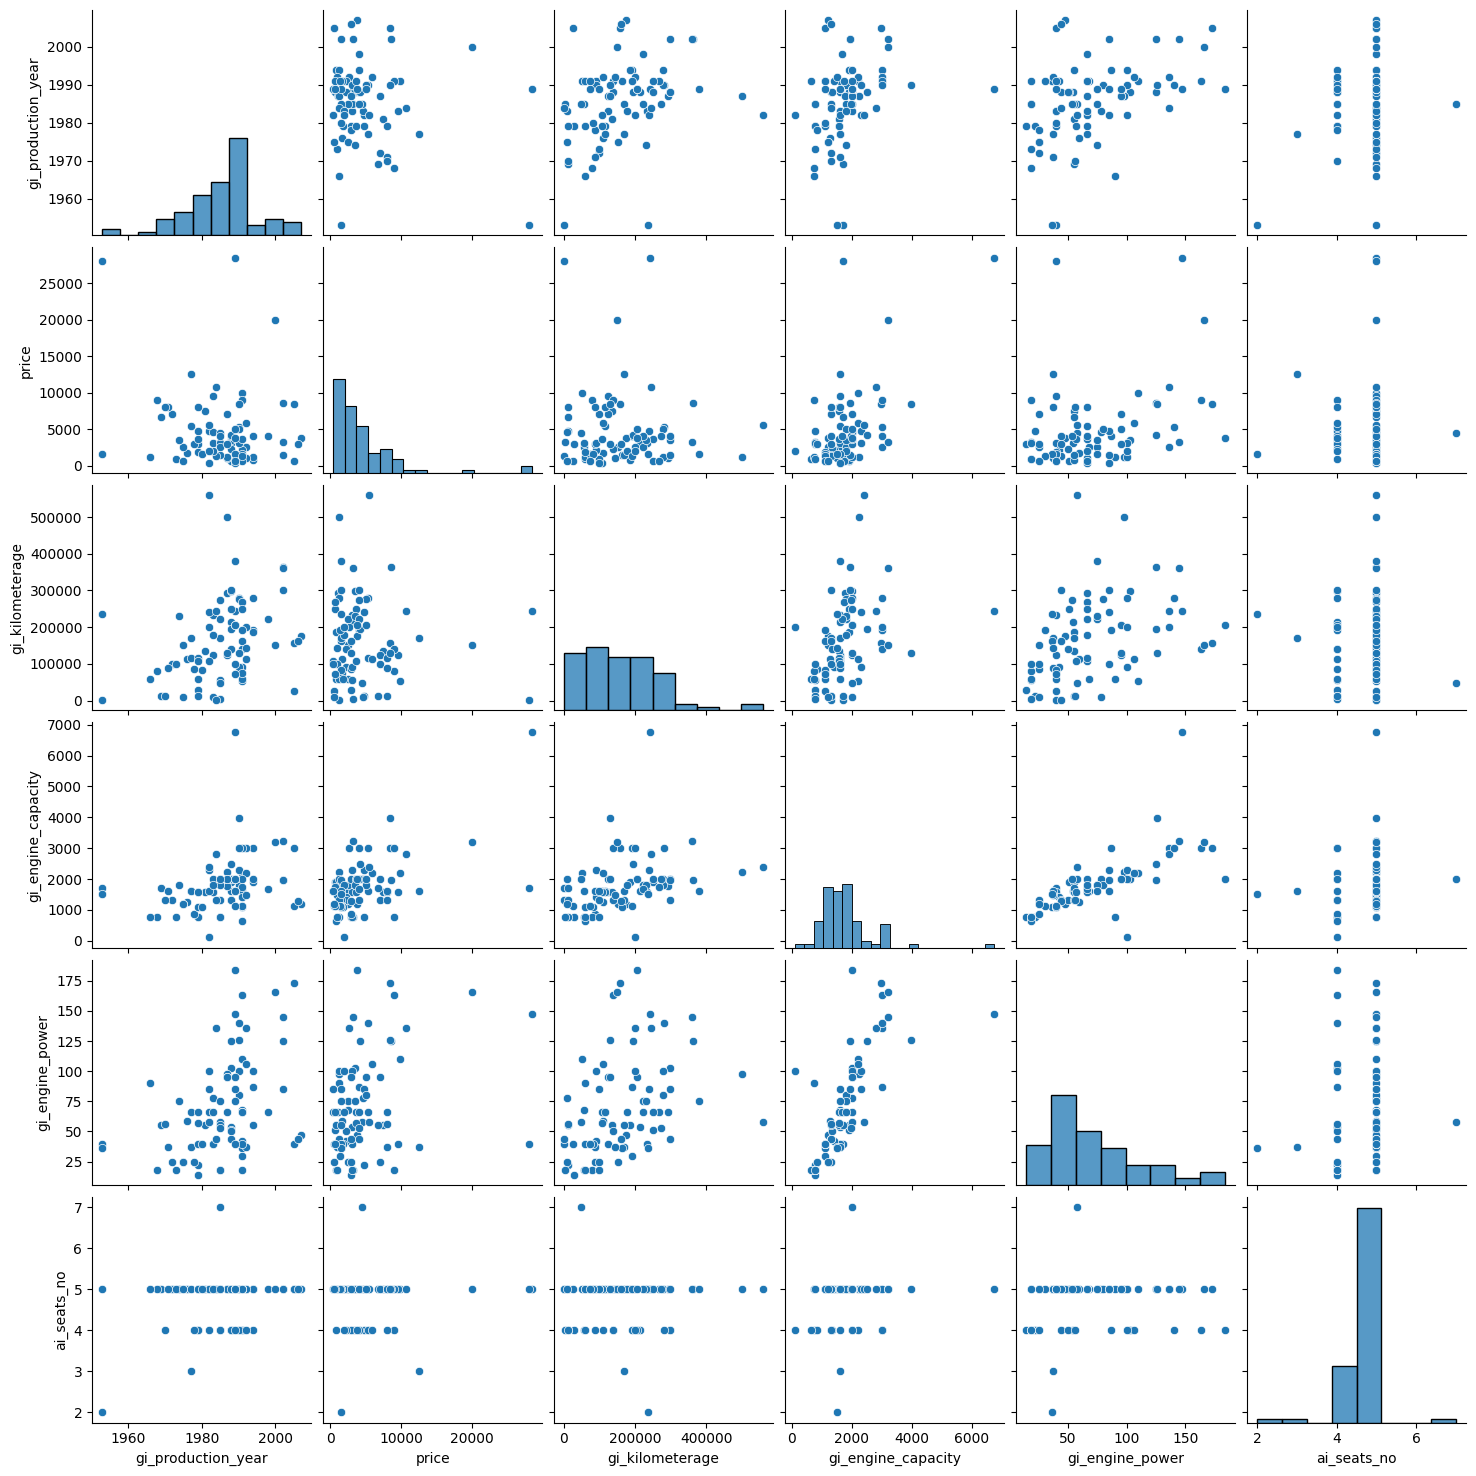


Oldtimer cars with 'ai_seats_no' = 2


,name,gi_production_year,price,short_url,gi_kilometerage,gi_engine_capacity,gi_engine_power,ai_seats_no,o_Restauriran
id,,,,,,,,,
23205081,Jeep Willys,1953,1600,https://www.polovniautomobili.com/auto-oglasi/...,235687,1500,36,2,False



Dropped oldtimer cars with 'ai_seats_no' = 2

Oldtimers produced before year 2000
Univariate analysis of 'gi_production_year' column
Histogram and box plot


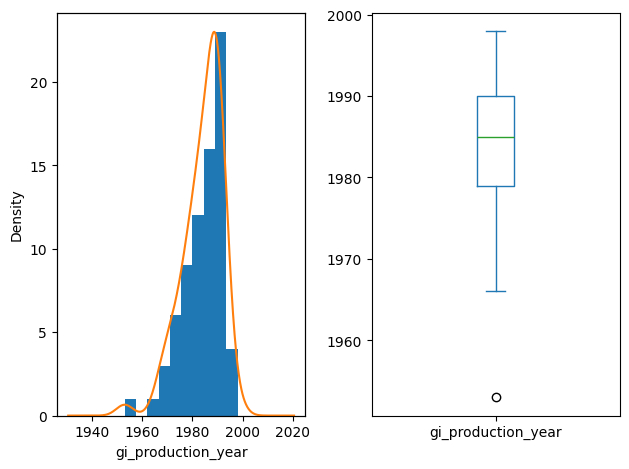

Descriptive statistics


count           75.0
mean     1984.053333
std         7.914908
min           1953.0
25%           1979.0
50%           1985.0
75%           1990.0
max           1998.0
Name: gi_production_year, dtype: Float64

Variance: 0.003989261621610168
Skewness: -1.1973129824620152
Kurtosis: 1.9158968551073885

NA values
Count [n]: 0
Percentage [%]: 0.0%


In [36]:
df, metadata = oldtimers(df=df, metadata=metadata)

### High seats cars

In [37]:
@preprocess_init
def high_seats_cars(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    idx_to_remove = metadata.idx_to_remove

    high_seats_no = 5
    high_seats = df.loc[df.ai_seats_no > high_seats_no, ["name", "ai_seats_no"]]

    print("Frequencies of 'ai_seats_no' of extreme high number of seats cars")
    display(high_seats.ai_seats_no.value_counts())
    print()

    extreme_high_seats_no = 7
    print(f"Cars where 'ai_seats_no' > {extreme_high_seats_no}")
    more_than_7_seats = high_seats[high_seats.ai_seats_no > extreme_high_seats_no]
    display(more_than_7_seats)
    print()

    df.drop(more_than_7_seats.index, axis=0, inplace=True)
    print(f"Dropped cars where 'ai_seats_no' > {extreme_high_seats_no}")

    idx_to_remove.extend(more_than_7_seats.index.tolist())

    return df, metadata

In [38]:
df, metadata = high_seats_cars(df=df, metadata=metadata)

Frequencies of 'ai_seats_no' of extreme high number of seats cars


ai_seats_no
7    929
6     47
8     13
9      8
Name: count, dtype: Int64


Cars where 'ai_seats_no' > 7


,name,ai_seats_no
id,,
12665476,Lincoln Town car STRETCHLIMO,8
15786162,Toyota Land Cruiser,8
19878811,Chevrolet Suburban,9
20229898,Ford Tourneo Connect 8 SEDISTA,8
22021029,Toyota Land Cruiser 3.0 D4D,8
22245391,Mercedes Benz G 300 G300,9
22503186,Toyota Land Cruiser PRADO,8
22544814,Mercedes Benz G 300 Puh,9
22628255,Peugeot Expert Orig.kilom.Garan.,8



Dropped cars where 'ai_seats_no' > 7


### Clean low kilometerage cars

In [39]:
@preprocess_init
def low_kilometerage_cars(df: Dataset, metadata: Metadata) -> tuple[Dataset, Metadata]:
    idx_to_remove = metadata.idx_to_remove

    low_kilometerage_amount = 500
    print(f"Cars where 'gi_kilometerage' < {low_kilometerage_amount}")
    low_kilometerage_cars = df.loc[
        df["gi_kilometerage"] < low_kilometerage_amount,
        ["name", "short_url", "price", "gi_kilometerage"],
    ]
    display(low_kilometerage_cars)
    print()

    df.drop(low_kilometerage_cars.index, axis=0, inplace=True)
    print(f"Dropped cars where 'gi_kilometerage' < {low_kilometerage_amount}")

    idx_to_remove.extend(low_kilometerage_cars.index.tolist())

    return df, metadata

In [40]:
df, metadata = low_kilometerage_cars(df=df, metadata=metadata)

Cars where 'gi_kilometerage' < 500


,name,short_url,price,gi_kilometerage
id,,,,
18764867,BMW X3 2.0xDrive LCI,https://www.polovniautomobili.com/auto-oglasi/...,68350,2
19795029,Kia Sportage 1.6 T-GDi LX Fresh,https://www.polovniautomobili.com/auto-oglasi/...,28019,5
20291479,Ford Kuga 1.5 Ecoboost,https://www.polovniautomobili.com/auto-oglasi/...,29090,10
20309884,ZhiDou D2S ELECTRIC,https://www.polovniautomobili.com/auto-oglasi/...,18000,2
20875715,Škoda Superb 2.0TDI/4x4/DSG/200ps,https://www.polovniautomobili.com/auto-oglasi/...,39990,1
21145833,"Dacia Sandero stepway 1,0 tce 90",https://www.polovniautomobili.com/auto-oglasi/...,16660,5
21341077,Kia Sportage 1.6 T-GDi 7DCT GT,https://www.polovniautomobili.com/auto-oglasi/...,40019,5
21446906,Ford Mustang GT 5.0 V8,https://www.polovniautomobili.com/auto-oglasi/...,71990,1
21478581,Nissan X-Trail TEKNA HYBRID DEMO,https://www.polovniautomobili.com/auto-oglasi/...,48990,50



Dropped cars where 'gi_kilometerage' < 500


## Testing

### Test individual components

In [41]:
def get_func_from_globals(func: Callable) -> Callable:
    result_func_name: str = func.__name__
    result_func: Callable = globals()[result_func_name]

    if not callable(result_func):
        raise Exception(
            f"Provided function {func.__name__} is not a function in globals."
        )
    return result_func


class TestNotebook(nb_utils.TestNotebookGeneric):
    def df(self) -> Dataset:
        return get_dataset_from_db()

    def metadata(self) -> Metadata:
        return get_metadata()

    def _test_funcs_with_preconditions(self):
        transf_obj: InitialCleaner = self.transformer_obj  # type: ignore

        # Test 'c_additional_informations' & 'c_general_informations'
        df_prep, metadata_prep = transf_obj.initial_preparation(
            self.df(), self.metadata()
        )
        prep_funcs_to_test: list[Callable] = [
            transf_obj.c_additional_informations,
            transf_obj.c_general_informations,
        ]

        for func_to_test in prep_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep,
                metadata=metadata_prep,
            )

        # Test funcs that depend on initial_cleaning
        df_prep_cr, metadata_prep_cr = transf_obj.initial_preparation(
            self.df(), self.metadata()
        )
        prep_funcs_to_test = [
            transf_obj.new_cars,
            transf_obj.irregular_label_rows,
        ]

        for func_to_test in prep_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep_cr,
                metadata=metadata_prep_cr,
            )

        # Test funcs that depend on initial cleaning, c_additional_info,
        # c_general_info and cf_other
        df_prep_cr, metadata_prep_cr = transf_obj.initial_preparation(
            self.df(), self.metadata()
        )
        df_prep_cr, metadata_prep_cr = transf_obj.cf_other(df_prep_cr, metadata_prep_cr)
        df_prep_cr, metadata_prep_cr = transf_obj.c_additional_informations(
            df_prep_cr, metadata_prep_cr
        )
        df_prep_cr, metadata_prep_cr = transf_obj.c_general_informations(
            df_prep_cr, metadata_prep_cr
        )
        prep_funcs_to_test = [
            transf_obj.oldtimers,
            transf_obj.high_seats_cars,
            transf_obj.low_kilometerage_cars,
        ]

        for func_to_test in prep_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(
                func_to_test,
                get_func_from_globals(func_to_test),
                df=df_prep_cr,
                metadata=metadata_prep_cr,
            )

    def test_single_funcs(self):
        transf_obj: InitialCleaner = self.transformer_obj  # type: ignore

        # Get all methods in InitialCleaner class with prefix 'cf_'
        cf_funcs_py: list[Callable] = [
            getattr(InitialCleaner, func)
            for func in dir(InitialCleaner)
            if func.startswith(nb_utils.CF_PREFIX)
            and callable(getattr(InitialCleaner, func))
        ]

        all_funcs_to_test: list[Callable] = [
            transf_obj.initial_preparation,
            *cf_funcs_py,
        ]

        for func_to_test in all_funcs_to_test:
            print(f"{func_to_test.__name__=}")
            self._test_single_func(func_to_test, get_func_from_globals(func_to_test))

        self._test_funcs_with_preconditions()

    def test_whole_component(
        self,
        df_init_py: Dataset,
        metadata_init_py: Metadata,
        df_nb: Dataset,
        metadata_nb: Metadata,
    ):
        self._test_whole_component(df_init_py, metadata_init_py, df_nb, metadata_nb)

In [ ]:
test_obj = TestNotebook(InitialCleaner())
test_obj.test_single_funcs()

### Test whole component

In [43]:
test_obj.test_whole_component(df_init_py=get_dataset_from_db(), metadata_init_py=Metadata(), df_nb=df, metadata_nb=metadata)

## Save cleaned data and metadata in artifacts

In [44]:
nb_utils.save_artifacts(STAGE, df, metadata)